In [ ]:
import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, Dense

#### Binarized MNIST Dataset

This notebook makes use of a specific binarization of the MNIST images. This dataset is frequently used to evaluate generative models of images, so labels are not provided.

The dataset was first introduced in the following paper:

* Salakhutdinov, R. and Murray, I. (2008), "On the quantitative analysis of deep belief networks", in *Proceedings of the 25th international conference on Machine learning*, 892-879.

This dataset is available from the [TensorFlow Datasets](https://www.tensorflow.org/datasets) library in prepared train/validation/test splits, and can be loaded into TF Dataset objects by running the following cell.

In [ ]:
# Load a binarised version of MNIST

import tensorflow_datasets as tfds

train_ds, val_ds, test_ds = tfds.load('binarized_mnist', data_dir='data', split=['train', 'validation', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling data/binarized_mnist/incomplete.2NUGTL_1.0.0/binarized_mnist-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling data/binarized_mnist/incomplete.2NUGTL_1.0.0/binarized_mnist-validation.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling data/binarized_mnist/incomplete.2NUGTL_1.0.0/binarized_mnist-test.tfrecord*...:   0%|          | 0/1…

Dataset binarized_mnist downloaded and prepared to data/binarized_mnist/1.0.0. Subsequent calls will reuse this data.


#### Variational autoencoder

I will experiment with and analyse variants of the variational autoencoder algorithm. This will involve modifications to the objective function and the variational posterior.

In [ ]:
from keras.metrics import Mean
import tensorflow as tf
import torch


class VAE(Model):

    def __init__(self, encoder, decoder, num_mc_samples=1, **kwargs):
        """
        I will override this method as necessary in my implementations.
        """
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_metric = Mean(name='loss')
        self.nll_metric = Mean(name='nll')
        self.kl_metric = Mean(name='kl')
        self.pi = ops.array(np.pi)
        self.L = num_mc_samples
        
    def compute_losses(self, data):
        """
        This method computes and returns the loss, kl_loss and nll_loss.
        I will override this method as necessary in my implementations.
        """
        z_mean, z_log_var = self.encoder(data)
        kl_loss = 0.5 * ops.sum((ops.square(z_mean) + ops.exp(z_log_var) - 1 - z_log_var), axis=-1)
        kl_loss = ops.mean(kl_loss)
        
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(0.5 * z_log_var)
        z_sample = z_mean + (z_std * epsilon)
        
        x_mean, x_log_std = self.decoder(z_sample)
        log_Z = 0.5 * ops.log(2 * self.pi)
        nll_loss = 0.5 * ops.square((data - x_mean) / ops.exp(x_log_std)) + x_log_std + log_Z
        nll_loss = ops.mean(ops.sum(nll_loss, axis=[-1, -2]))

        loss = kl_loss + nll_loss
        return loss, kl_loss, nll_loss

    def call(self, inputs):
        """
        This method computes the approximate posterior using the encoder, 
        and draws a single sample to pass through the decoder.
        I will override this method as necessary in my implementations.
        """
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(0.5 * z_log_var)
        z_sample = z_mean + (z_std * epsilon)
        return self.decoder(z_sample)

    def train_step(self, data):
        if keras.config.backend() == 'tensorflow':
            with tf.GradientTape() as tape:
                loss, kl_loss, nll_loss = self.compute_losses(data)
                loss = ops.mean(loss)
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        else:
            assert keras.config.backend() == 'torch'
            self.zero_grad()
            loss, kl_loss, nll_loss = self.compute_losses(data)
            loss = ops.mean(loss)

            loss.backward()

            gradients = [v.value.grad for v in self.trainable_weights]    
            with torch.no_grad():
                self.optimizer.apply(gradients, self.trainable_weights)
            
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        loss, kl_loss, nll_loss = self.compute_losses(data)
        loss = ops.mean(loss)
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    @property
    def metrics(self):
        return [self.loss_metric, self.nll_metric, self.kl_metric]

In [ ]:
from keras.layers import Flatten
from keras.layers import Reshape
from keras.callbacks import EarlyStopping
from keras.models import load_model

batch_size = 32
latent_dim = 2

Using the `train_ds`, `val_ds` and `test_ds` objects returned above, prepare the Datasets ready for training and evaluating the model that will be trained using the VAE algorithm.

In [ ]:
def preprocess(example):
    """Extract and cast the image to float32."""
    image = tf.cast(example['image'], tf.float32)
    return image

def prepare_dataset(dataset, batch_size=batch_size, shuffle=False):
    """Preprocess, optionally shuffle, batch, and prefetch the dataset."""
    dataset = dataset.map(preprocess)
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds)
test_ds = prepare_dataset(test_ds, batch_size=1)

Train batch shape: (32, 28, 28, 1)
Distinct pixel values in batch: [0. 1.]


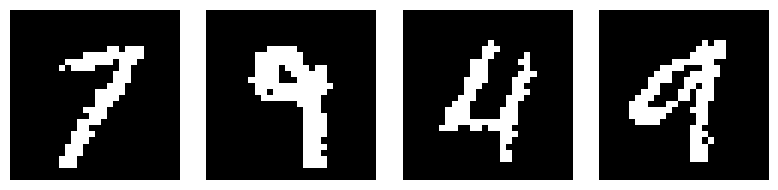

In [ ]:
# Dataset verification
for batch in train_ds.take(1):
    print("Train batch shape:", batch.shape)

    unique_vals = tf.unique(tf.reshape(batch, [-1]))[0].numpy()
    print("Distinct pixel values in batch:", np.sort(unique_vals))

    idx = np.random.choice(batch.shape[0], size=4, replace=False)
    plt.figure(figsize=(8, 2))
    for i, j in enumerate(idx):
        plt.subplot(1, 4, i + 1)
        plt.imshow(tf.squeeze(batch[j]), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Implement the VAE algorithm to learn a generative model of the binarized MNIST dataset. In particular, I will define encoder and decoder networks, and write a `VAEDiagonal` class that implements the training update and evaluation steps using the ELBO $\mathcal{L}_{VAE}(\theta, \phi; {x})$ as the objective function that we wish to maximise:

$$
\mathcal{L}_{VAE}(\theta, \phi; {x}) := 
 \mathbb{E}_{z\sim q_\phi({z}\mid {x})} \left[ \log p_\theta({x}, {z}) - \log q_\phi({z}\mid {x}) \right] \le \log p_\theta(x).
$$

* The `VAEDiagonal` class will subclass from the `VAE` class above
* The encoder network will use a fully factorised (diagonal) Gaussian for the approximate posterior $q_\phi(z \mid x)$
* The latent space will have dimension 2
* The ELBO objective will be approximated using the second form of the SGVB estimator:
$$
\hat{\mathcal{L}}^B(\theta,\phi;x)[q_\phi] := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x\mid z^{(j)}) − D_{KL}(q_\phi(z\mid x) || p_\theta(z)),
$$
  * I will set $L=1$ in the model that I train (use a single Monte Carlo sample)
* The likelihood distribution $p_\theta(x\mid z^{(j)})$ will be chosen appropriately for the binary data.

In [ ]:
# Define the encoder
encoder_input = Input(shape=(28, 28, 1))
x = Flatten()(encoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoder_diag = Model(encoder_input, [z_mean, z_log_var], name="encoder_diag")
encoder_diag.summary()

Model: "encoder_diag"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        401,920 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │            514 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 534,276 (2.04 MB)

 Trainable params: 534,276 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(decoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
decoder_output = Reshape((28, 28, 1))(x)
decoder_diag = Model(decoder_input, decoder_output, name="decoder_diag")
decoder_diag.summary()

Model: "decoder_diag"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,544 (2.04 MB)

 Trainable params: 534,544 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Custom VAE class with ELBO loss (diagonal Gaussian posterior)
class VAEDiagonal(VAE):
    def __init__(self, encoder, decoder, num_mc_samples=1, **kwargs):
        super().__init__(encoder, decoder, num_mc_samples, **kwargs)

    def compute_losses(self, data):
        """Compute ELBO loss for VAE with diagonal Gaussian posterior (L=1)."""
        # Sample z ~ q(z|x) using reparameterisation
        z_mean, z_log_var = self.encoder(data)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        # Compute log-likelihood log p(x|z) using binary cross-entropy
        x_recon = self.decoder(z)
        x_flat = tf.reshape(data, [tf.shape(data)[0], -1])
        x_recon_flat = tf.reshape(x_recon, [tf.shape(x_recon)[0], -1])
        bce = tf.keras.backend.binary_crossentropy(x_flat, x_recon_flat)
        nll_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=1))
        # Compute KL divergence
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        kl_loss = tf.reduce_mean(kl_loss)
        # Negative ELBO = −log p(x|z) + KL(q‖p)
        loss = nll_loss + kl_loss
        return loss, kl_loss, nll_loss

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Instantiate, compile and fit the model
vae_diag = VAEDiagonal(encoder_diag, decoder_diag)
vae_diag.compile(optimizer='adam')
history_diag = vae_diag.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - kl: 5.3164 - loss: 195.0545 - nll: 189.7381 - val_kl: 5.3538 - val_loss: 161.2306 - val_nll: 155.8768
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - kl: 5.2904 - loss: 159.6216 - nll: 154.3313 - val_kl: 5.7419 - val_loss: 156.1177 - val_nll: 150.3757
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - kl: 5.6489 - loss: 154.8171 - nll: 149.1683 - val_kl: 5.8681 - val_loss: 152.9596 - val_nll: 147.0915
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - kl: 5.8577 - loss: 152.1558 - nll: 146.2981 - val_kl: 6.1528 - val_loss: 150.9322 - val_nll: 144.7794
Epoch 5/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - kl: 5.9845 - loss: 150.3020 - nll: 144.3174 - val_kl: 6.1305 - val_loss: 150.0061 - val_nll: 143.8756
Epoch 6/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - kl: 6.1340 - loss: 148.3033 - nll: 142.1693 - val_kl: 6.1417 - val_loss: 148.8214 - val_nll: 142.6797
Epoch 7/200
1563/1563 ━━━━━━━━━━━━

In [ ]:
elbo_diag = vae_diag.evaluate(test_ds, return_dict=True)['loss']
print(f"ELBO (diagonal Gaussian posterior): {elbo_diag:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - kl: 6.8868 - loss: 141.4158 - nll: 134.5291
ELBO (diagonal Gaussian posterior): 141.6767


In [ ]:
# Save the model
encoder_diag.save("encoder_diag.keras")
decoder_diag.save("decoder_diag.keras")

Implement a `VAEFullCovariance` class to train a second model using the VAE algorithm, where the encoder network now parameterises a general (full covariance) multivariate Gaussian distribution over the 2-dimensional latent space. I will use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to parameterise the covariance matrix. The architectural design of the encoder and decoder networks will otherwise be identical to the model above.

* The `VAEFullCovariance` class will subclass from the `VAE` class above
* The latent space will have dimension 2
* The ELBO objective will be approximated using the second form of the SGVB estimator:
$$
\hat{\mathcal{L}}^B(\theta,\phi;x) := \frac{1}{L} \sum_{j=1}^L \log p_\theta(x\mid z^{(j)}) − D_{KL}(q_\phi(z\mid x) || p_\theta(z)),
$$
  * I will set $L=1$ in the model that I train (use a single Monte Carlo sample)
* The likelihood distribution $p_\theta(x\mid z^{(j)})$ will be chosen appropriately for the binary data.

In [ ]:
# Define the encoder
encoder_input = Input(shape=(28, 28, 1))
x = Flatten()(encoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
z_mean = Dense(latent_dim)(x)
z_chol = Dense(3)(x)
encoder_fullcov = Model(encoder_input, [z_mean, z_chol], name="encoder_fullcov")
encoder_fullcov.summary()

Model: "encoder_fullcov"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 784)            │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        401,920 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 2)              │            514 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 3)              │            771 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 534,533 (2.04 MB)

 Trainable params: 534,533 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(decoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
decoder_output = Reshape((28, 28, 1))(x)
decoder_fullcov = Model(decoder_input, decoder_output, name="decoder_fullcov")
decoder_fullcov.summary()

Model: "decoder_fullcov"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,544 (2.04 MB)

 Trainable params: 534,544 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Custom VAE class with ELBO loss (full covariance Gaussian posterior)
class VAEFullCovariance(VAE):
    def __init__(self, encoder, decoder, num_mc_samples=1, **kwargs):
        super().__init__(encoder, decoder, num_mc_samples, **kwargs)

    def compute_losses(self, data):
        """Compute ELBO loss for VAE with full covariance Gaussian posterior (L=1)."""
        # Sample z ~ q(z|x) using reparameterisation with Cholesky decomposition
        z_mean, z_chol = self.encoder(data)
        L11 = tf.exp(z_chol[:, 0])
        L21 = z_chol[:, 1]
        L22 = tf.exp(z_chol[:, 2])
        L = tf.stack([
            tf.stack([L11, tf.zeros_like(L11)], axis=1),
            tf.stack([L21, L22], axis=1)
        ], axis=1)
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], 2, 1))
        z = z_mean[:, :, tf.newaxis] + tf.matmul(L, epsilon)
        z = tf.squeeze(z, axis=-1)
        # Compute log-likelihood log p(x|z) using binary cross-entropy
        x_recon = self.decoder(z)
        nll_loss = tf.keras.losses.binary_crossentropy(data, x_recon)
        nll_loss = tf.reduce_mean(tf.reduce_sum(nll_loss, axis=[1, 2]))
        # Compute KL divergence
        log_det_sigma = 2.0 * (tf.math.log(L11) + tf.math.log(L22))
        tr_sigma = L11**2 + L21**2 + L22**2
        mu_squared = tf.reduce_sum(tf.square(z_mean), axis=1)
        kl_loss = 0.5 * (tr_sigma + mu_squared - 2 - log_det_sigma)
        kl_loss = tf.reduce_mean(kl_loss)
        # Negative ELBO = −log p(x|z) + KL(q‖p)
        loss = nll_loss + kl_loss
        return loss, kl_loss, nll_loss

In [ ]:
# Instantiate, compile and fit the model
vae_fullcov = VAEFullCovariance(encoder_fullcov, decoder_fullcov)
vae_fullcov.compile(optimizer='adam')
history_fullcov = vae_fullcov.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - kl: 5.2206 - loss: 198.6994 - nll: 193.4787 - val_kl: 5.4289 - val_loss: 163.7089 - val_nll: 158.2800
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl: 5.2307 - loss: 160.6795 - nll: 155.4488 - val_kl: 5.7439 - val_loss: 156.9157 - val_nll: 151.1718
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - kl: 5.6863 - loss: 154.4079 - nll: 148.7217 - val_kl: 5.9482 - val_loss: 152.5370 - val_nll: 146.5889
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - kl: 5.9486 - loss: 150.8917 - nll: 144.9432 - val_kl: 5.9901 - val_loss: 149.7858 - val_nll: 143.7957
Epoch 5/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - kl: 6.0958 - loss: 148.7157 - nll: 142.6200 - val_kl: 6.2588 - val_loss: 148.6651 - val_nll: 142.4063
Epoch 6/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl: 6.2177 - loss: 146.7025 - nll: 140.4848 - val_kl: 5.9966 - val_loss: 148.2884 - val_nll: 142.2917
Epoch 7/200
1563/1563 ━━━━━━━━━━━━

In [ ]:
elbo_fullcov = vae_fullcov.evaluate(test_ds, return_dict=True)['loss']
print(f"ELBO (full covariance Gaussian posterior): {elbo_fullcov:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - kl: 6.9456 - loss: 140.2636 - nll: 133.3182
ELBO (full covariance Gaussian posterior): 140.2004


In [ ]:
# Save the model
encoder_fullcov.save("encoder_fullcov.keras")
decoder_fullcov.save("decoder_fullcov.keras")

The importance weighted autoencoder (IWAE) objective is defined as

$$
\mathcal{L}_{IWAE}^k(\theta, \phi; x) := \mathbb{E}_{z_1,\ldots,z_k\sim q_\phi({z}\mid {x})} \left[ \log \frac{1}{k} \sum_{i=1}^k \frac{p_\theta({x}, {z_i})}{q_\phi({z_i}\mid {x})} \right],
$$

where $k\ge 1$ is a positive integer. The IWAE objective can be used as an optimisation objective instead of the VAE ELBO $\mathcal{L}_{VAE}$. The IWAE objective was introduced in the following paper, where it is shown that, similar to the VAE ELBO, $\mathcal{L}_{IWAE}^k$ is a lower bound on the marginal likelihood, and that $\log p_\theta(x) \ge \mathcal{L}_{IWAE}^{k+1} \ge \mathcal{L}_{IWAE}^k$. It is also shown (under certain conditions on $q_\phi(z\mid x)$) that $\mathcal{L}_{IWAE}^k \to \log p_\theta(x)$ as $k\to\infty$.

* Burda, Y., Grosse, R. and Salakhutdinov, R. (2015), "Importance Weighted Autoencoders", arXiv preprint, abs/1509.00519.

In Burda et al, it is proposed to use $\mathcal{L}_{IWAE}^k$ with $k=5000$ as a approximation of the true log-likelihood $\log p_\theta(x)$. 

I will use this approximation of the log-likelihood to compute the negative log-likelihood (NLL) for the models trained above. I will use a single Monte Carlo sample for each $z_1,\ldots,z_k$ (in other words, I will take a single sample of the vector $(z_1,\ldots,z_k)$) in the approximation of the expectation above.

In [ ]:
encoder_diag = load_model("encoder_diag.keras")
decoder_diag = load_model("decoder_diag.keras")
encoder_fullcov = load_model("encoder_fullcov.keras")
decoder_fullcov = load_model("decoder_fullcov.keras")
vae_diag = VAEDiagonal(encoder_diag, decoder_diag)
vae_fullcov = VAEFullCovariance(encoder_fullcov, decoder_fullcov)

In [ ]:
def estimate_nll_iwae_diag(model, dataset, k=5000):
    """Estimate negative log-likelihood using IWAE (k samples) for VAE with
    diagonal Gaussian posterior."""
    log_likelihoods = []
    total_batches = tf.data.experimental.cardinality(dataset).numpy()
    for i, batch in enumerate(dataset):
        x = tf.cast(batch, tf.float32)
        batch_size = tf.shape(x)[0]
        latent_dim = tf.shape(model.encoder(x)[0])[-1]
        # Encode input to obtain parameters of q(z|x) (mean and log-variance)
        z_mean, z_log_var = model.encoder(x)
        z_std = tf.exp(0.5 * z_log_var)
        # Draw k samples from the variational posterior using reparameterisation
        epsilon = tf.random.normal(shape=(k, batch_size, latent_dim))
        z_samples = z_mean[None, :, :] + epsilon * z_std[None, :, :]
        # Decode each sample z_i to compute p(x|z_i)
        z_flat = tf.reshape(z_samples, [-1, latent_dim])
        x_recon = model.decoder(z_flat)
        x_recon = tf.reshape(x_recon, [k, batch_size, 28 * 28])
        x_flat = tf.reshape(x, [batch_size, 28 * 28])
        # Compute log-likelihood log p(x|z) using binary cross-entropy
        bce = tf.keras.backend.binary_crossentropy(x_flat[None, :, :], x_recon)
        log_p_x_given_z = -tf.reduce_sum(bce, axis=-1)
        # Compute log p(z) under the standard normal prior
        log_p_z = -0.5 * tf.reduce_sum(z_samples**2 + tf.math.log(2. * np.pi), axis=-1)
        # Compute log q(z|x) under the diagonal Gaussian variational posterior
        z_var = tf.exp(z_log_var)
        log_q_z = -0.5 * tf.reduce_sum(
            ((z_samples - z_mean[None, :, :]) ** 2) / z_var[None, :, :]
            + z_log_var[None, :, :]
            + tf.math.log(2. * np.pi),
            axis=-1
        )
        # Importance weights: log w_i = log p(x,z_i) − log q(z_i|x)
        log_w = log_p_x_given_z + log_p_z - log_q_z
        log_likelihood = tf.reduce_logsumexp(log_w, axis=0) - tf.math.log(tf.cast(k, tf.float32))
        log_likelihoods.append(log_likelihood)
        # Report progress every 1000 batches
        if (i + 1) % 1000 == 0 or (i + 1) == total_batches:
            print(f"Processed {i + 1} / {total_batches} batches")
    log_likelihoods = tf.concat(log_likelihoods, axis=0)
    nll = -tf.reduce_mean(log_likelihoods)
    return nll.numpy()

In [ ]:
def estimate_nll_iwae_fullcov(model, dataset, k=5000):
    """Estimate negative log-likelihood using IWAE (k samples) for VAE with full
    covariance Gaussian posterior."""
    log_likelihoods = []
    total_batches = tf.data.experimental.cardinality(dataset).numpy()
    for i, batch in enumerate(dataset):
        x = tf.cast(batch, tf.float32)
        batch_size = tf.shape(x)[0]
        latent_dim = 2
        # Encode input to obtain mean and Cholesky factors of q(z|x)
        z_mean, z_chol = model.encoder(x)
        L11 = tf.exp(z_chol[:, 0])
        L21 = z_chol[:, 1]
        L22 = tf.exp(z_chol[:, 2])
        L = tf.stack([
            tf.stack([L11, tf.zeros_like(L11)], axis=1),
            tf.stack([L21, L22], axis=1)
        ], axis=1)
        # Draw k samples z_i from full-covariance q(z|x) via Cholesky reparameterisation
        epsilon = tf.random.normal(shape=(k, batch_size, latent_dim, 1))
        z_samples = z_mean[None, :, :, None] + tf.matmul(L[None, :, :, :], epsilon)
        z_samples = tf.squeeze(z_samples, axis=-1)
        # Decode each sample z_i to compute p(x|z_i)
        z_flat = tf.reshape(z_samples, [-1, latent_dim])
        x_recon = model.decoder(z_flat)
        x_recon = tf.reshape(x_recon, [k, batch_size, 28 * 28])
        x_flat = tf.reshape(x, [batch_size, 28 * 28])
        # Compute log-likelihood log p(x|z) using binary cross-entropy
        bce = tf.keras.backend.binary_crossentropy(x_flat[None, :, :], x_recon)
        log_p_x_given_z = -tf.reduce_sum(bce, axis=-1)
        # Compute log p(z) under the standard normal prior
        log_p_z = -0.5 * tf.reduce_sum(z_samples**2 + tf.math.log(2. * np.pi), axis=-1)
        # Compute log q(z|x) under full covariance Gaussian using Mahalanobis distance
        delta = z_samples - z_mean[None, :, :]
        L_tiled = tf.repeat(L[None, :, :, :], repeats=k, axis=0)
        delta_expanded = tf.expand_dims(delta, axis=-1)
        y = tf.linalg.triangular_solve(L_tiled, delta_expanded, lower=True)
        y = tf.squeeze(y, axis=-1)
        mahalanobis = tf.reduce_sum(tf.square(y), axis=-1)
        log_det = 2.0 * (tf.math.log(L11) + tf.math.log(L22))
        log_det = tf.broadcast_to(log_det[None, :], tf.shape(mahalanobis))
        log_q_z = -0.5 * (mahalanobis + log_det + latent_dim * tf.math.log(2. * np.pi))
        # Importance weights: log w_i = log p(x,z_i) − log q(z_i|x)
        log_w = log_p_x_given_z + log_p_z - log_q_z
        log_likelihood = tf.reduce_logsumexp(log_w, axis=0) - tf.math.log(tf.cast(k, tf.float32))
        log_likelihoods.append(log_likelihood)
        # Report progress every 1000 batches
        if (i + 1) % 1000 == 0 or (i + 1) == total_batches:
            print(f"Processed {i + 1} / {total_batches} batches")
    log_likelihoods = tf.concat(log_likelihoods, axis=0)
    nll = -tf.reduce_mean(log_likelihoods)
    return nll.numpy()

In [ ]:
nll_diag = estimate_nll_iwae_diag(vae_diag, test_ds, k=5000)
print(f"NLL (IWAE, k=5000, diagonal Gaussian posterior): {nll_diag:.4f}")

nll_fullcov = estimate_nll_iwae_fullcov(vae_fullcov, test_ds, k=5000)
print(f"NLL (IWAE, k=5000, full covariance Gaussian posterior): {nll_fullcov:.4f}")

Processed 1000 / 10000 batches
Processed 2000 / 10000 batches
Processed 3000 / 10000 batches
Processed 4000 / 10000 batches
Processed 5000 / 10000 batches
Processed 6000 / 10000 batches
Processed 7000 / 10000 batches
Processed 8000 / 10000 batches
Processed 9000 / 10000 batches
Processed 10000 / 10000 batches
NLL (IWAE, k=5000, diagonal Gaussian posterior): 137.1439
Processed 1000 / 10000 batches
Processed 2000 / 10000 batches
Processed 3000 / 10000 batches
Processed 4000 / 10000 batches
Processed 5000 / 10000 batches
Processed 6000 / 10000 batches
Processed 7000 / 10000 batches
Processed 8000 / 10000 batches
Processed 9000 / 10000 batches
Processed 10000 / 10000 batches
NLL (IWAE, k=5000, full covariance Gaussian posterior): 135.6710


I will now train new encoder and decoder networks using the IWAE objective. The architectural design of the encoder and decoder networks will be identical to previously trained models, with the encoder parameterising a fully factorised (diagonal) Gaussian for the approximate posterior $q_\phi(z \mid x)$ (as in the `VAE` and `VAEDiagonal` classes). I will use a `IWAEDiagonal` class to implement this.

* The `IWAEDiagonal` class will subclass from the `VAE` class
* The latent space will have dimension 2
* The maximisation objective will be the IWAE objective $\mathcal{L}_{IWAE}^k$ with $k=50$. The expectation in the IWAE objective will be approximated using a single Monte Carlo sample for each $z_1,\ldots,z_k$
  * I will set $k=50$ in the model that I train, but the model class implementation will work for general $k$
* The likelihood distribution $p_\theta(x\mid z^{(j)})$ will be chosen appropriately for the binary data.

In [ ]:
# Define the encoder
encoder_input = Input(shape=(28, 28, 1))
x = Flatten()(encoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoder_iwae = Model(encoder_input, [z_mean, z_log_var], name="encoder_iwae")
encoder_iwae.summary()

Model: "encoder_iwae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        401,920 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │            514 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 534,276 (2.04 MB)

 Trainable params: 534,276 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(decoder_input)
x = Dense(512, activation="relu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
decoder_output = Reshape((28, 28, 1))(x)
decoder_iwae = Model(decoder_input, decoder_output, name="decoder_iwae")
decoder_iwae.summary()

Model: "decoder_iwae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,544 (2.04 MB)

 Trainable params: 534,544 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Custom VAE class with IWAE objective (diagonal Gaussian posterior)
class IWAEDiagonal(VAE):
    def __init__(self, encoder, decoder, num_mc_samples=50, **kwargs):
        super().__init__(encoder, decoder, num_mc_samples, **kwargs)

    def compute_losses(self, data):
        """Compute IWAE loss for VAE with diagonal Gaussian posterior."""
        # Sample z ~ q(z|x) using reparameterisation
        z_mean, z_log_var = self.encoder(data)
        batch_size = tf.shape(data)[0]
        latent_dim = tf.shape(z_mean)[-1]
        L = self.L
        z_std = tf.exp(0.5 * z_log_var)
        epsilon = tf.random.normal(shape=(L, batch_size, latent_dim))
        z_samples = z_mean[None, :, :] + epsilon * z_std[None, :, :]
        # Decode z to compute p(x|z)
        z_flat = tf.reshape(z_samples, [-1, latent_dim])
        x_recon = self.decoder(z_flat)
        x_recon = tf.reshape(x_recon, [L, batch_size, 28 * 28])
        x_flat = tf.reshape(data, [batch_size, 28 * 28])
        # Compute log-likelihood log p(x|z) using binary cross-entropy
        bce = tf.keras.backend.binary_crossentropy(x_flat[None, :, :], x_recon)
        log_p_x_given_z = -tf.reduce_sum(bce, axis=-1)
        # Compute log p(z) under the standard normal prior
        log_p_z = -0.5 * tf.reduce_sum(z_samples**2 + tf.math.log(2. * np.pi), axis=-1)
        # Compute log q(z|x) under the diagonal Gaussian variational posterior
        z_var = tf.exp(z_log_var)
        log_q_z = -0.5 * tf.reduce_sum(
            ((z_samples - z_mean[None, :, :]) ** 2) / z_var[None, :, :]
            + z_log_var[None, :, :]
            + tf.math.log(2. * np.pi),
            axis=-1
        )
        # IWAE objective = log(1/k sum_i w_i) where w_i = p(x,z_i)/q(z_i|x)
        log_w = log_p_x_given_z + log_p_z - log_q_z
        log_iw = tf.reduce_logsumexp(log_w, axis=0) - tf.math.log(tf.cast(L, tf.float32))
        loss = -tf.reduce_mean(log_iw)
        return loss, 0.0, 0.0

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Instantiate, compile and fit the model
iwae_diag = IWAEDiagonal(encoder_iwae, decoder_iwae, num_mc_samples=50)
iwae_diag.compile(optimizer='adam')
history_iwae = iwae_diag.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 248s 156ms/step - kl: 0.0000e+00 - loss: 184.9971 - nll: 0.0000e+00 - val_kl: 0.0000e+00 - val_loss: 155.7058 - val_nll: 0.0000e+00
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 241s 154ms/step - kl: 0.0000e+00 - loss: 152.4936 - nll: 0.0000e+00 - val_kl: 0.0000e+00 - val_loss: 147.5555 - val_nll: 0.0000e+00
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 233s 149ms/step - kl: 0.0000e+00 - loss: 145.6331 - nll: 0.0000e+00 - val_kl: 0.0000e+00 - val_loss: 143.4706 - val_nll: 0.0000e+00
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 265s 151ms/step - kl: 0.0000e+00 - loss: 142.1870 - nll: 0.0000e+00 - val_kl: 0.0000e+00 - val_loss: 140.7055 - val_nll: 0.0000e+00
Epoch 5/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 233s 149ms/step - kl: 0.0000e+00 - loss: 140.2192 - nll: 0.0000e+00 - val_kl: 0.0000e+00 - val_loss: 139.8915 - val_nll: 0.0000e+00
Epoch 6/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 237s 151ms/step - kl: 0.0000e+00 - loss: 138.9155 - nll: 0.0000e+00 - val_kl: 0.00

In [ ]:
iwae_k50_diag = iwae_diag.evaluate(test_ds, return_dict=True)['loss']
print(f"Test IWAE loss (k=50, diagonal Gaussian posterior): {iwae_k50_diag:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - kl: 0.0000e+00 - loss: 130.3842 - nll: 0.0000e+00
Test IWAE loss (k=50, diagonal Gaussian posterior): 130.3631


In [ ]:
# Save the model
encoder_iwae.save("encoder_iwae.keras")
decoder_iwae.save("decoder_iwae.keras")

We define the distribution $q^k_{IWAE}(z\mid x)$ by

$$
q^k_{IWAE}(z\mid x) = \mathbb{E}_{z_2,\ldots,z_k\sim q_\phi(z\mid x)}\left[ \frac{p_\theta(x, z)}{\frac{1}{k} \left( \frac{p_\theta(x, z)}{q_\phi(z \mid x)} + \sum_{j=2}^k \frac{p_\theta(x, z_j)}{q_\phi(z_j \mid x)} \right)} \right].
$$

I will now prove that $q^k_{IWAE}(z\mid x)$ is a valid normalised distribution; that is, $\int_z q^k_{IWAE}(z\mid x) dz = 1$.

$$
\int_{z} q^k_{IWAE}(z\mid x)\,dz = \int_{z} \mathbb{E}_{z_2,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{p_\theta(x, z)}{\frac{1}{k} \left( \frac{p_\theta(x,z)}{q_\phi(z\mid x)} + \sum_{j=2}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} \right)} \right] dz
$$

$$
= \int_{z} \frac{q_\phi(z\mid x)}{q_\phi(z\mid x)} \mathbb{E}_{z_2,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{p_\theta(x, z)}{\frac{1}{k} \left( \frac{p_\theta(x,z)}{q_\phi(z\mid x)} + \sum_{j=2}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} \right)} \right] dz
$$

$$
= \mathbb{E}_{z \sim q_\phi(z\mid x)} \mathbb{E}_{z_2,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{\frac{p_\theta(x,z)}{q_\phi(z\mid x)}}{\frac{1}{k} \left( \frac{p_\theta(x,z)}{q_\phi(z\mid x)} + \sum_{j=2}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} \right)} \right]
$$

$$
= \mathbb{E}_{z_1,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{\frac{p_\theta(x,z_1)}{q_\phi(z_1\mid x)}}{\frac{1}{k} \left( \sum_{j=1}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} \right)} \right]
$$

$$
= k \cdot \mathbb{E}_{z_1,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{\frac{p_\theta(x,z_1)}{q_\phi(z_1\mid x)}}{ \sum_{j=1}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} } \right]
$$

$$
= \sum_{i=1}^k \mathbb{E}_{z_1,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \frac{\frac{p_\theta(x,z_i)}{q_\phi(z_i\mid x)}}{ \sum_{j=1}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} } \right]
$$

$$
= \mathbb{E}_{z_1,\ldots,z_k \sim q_\phi(z\mid x)} \left[ \sum_{i=1}^k \frac{\frac{p_\theta(x,z_i)}{q_\phi(z_i\mid x)}}{ \sum_{j=1}^k \frac{p_\theta(x,z_j)}{q_\phi(z_j \mid x)} } \right]
$$

$$
= \mathbb{E}_{z_1,\ldots,z_k \sim q_\phi(z\mid x)} [1]
$$

$$
= 1
$$


It can be shown that (under certain conditions on $q_\phi(z\mid x)$) that the distribution $q^k_{IWAE}(z\mid x)$ converges to the true posterior distribution $p_\theta(z \mid x)$ as $k\to\infty$, in the sense that $D_{KL}(q^k_{IWAE}(z\mid x) \mid\mid p_\theta(z\mid x))$ converges to zero.

It can also be shown that as $k\to\infty$, we have that $\left|\mathcal{L}^k_{IWAE}(\theta,\phi; x) - \mathcal{L}_{VAE}(\theta,\phi; x)[q^k_{IWAE}]\right| \to 0$, where

$$
\mathcal{L}_{VAE}(\theta,\phi; x)[q^k_{IWAE}] := \mathbb{E}_{z\sim q^k_{IWAE}({z}\mid {x})} \left[ \log p_\theta({x}, {z}) - \log q^k_{IWAE}({z}\mid {x}) \right]
$$

That is, the IWAE objective converges to the VAE ELBO objective where the variational posterior $q_\phi(z \mid x)$ is replaced with $q^k_{IWAE}(z\mid x)$. 

Using my trained encoder and decoder networks from above, I will display some test images and their reconstructions using i) $q_\phi(z \mid x)$ and ii) $q^k_{IWAE}(z\mid x)$. The reconstructions displayed will be the mean of the likelihood distribution $p_\theta(x \mid z)$, where $z$ is a sample from the specified posterior distribution ($q_\phi(z \mid x)$ or $q^k_{IWAE}(z\mid x)$). I will set $k=50$ for the distribution $q^k_{IWAE}(z\mid x)$, as above.

The following algorithm will be used to sample from $q^k_{IWAE}(z\mid x)$:

<center><img src="figures/sampling_algorithm.png" alt="Sampling algorithm" style="width: 500px;"/></center>

In [ ]:
encoder_iwae = load_model("encoder_iwae.keras")
decoder_iwae = load_model("decoder_iwae.keras")
iwae_diag = IWAEDiagonal(encoder_iwae, decoder_iwae)

In [ ]:
def sample_from_q_iwae_k(x, model, k=50):
    """Sample from q^k_IWAE(z|x) using importance resampling."""
    x_tiled = tf.repeat(x, repeats=k, axis=0)
    # Sample z ~ q(z|x) using reparameterisation
    z_mean, z_log_var = model.encoder(x_tiled)
    z_std = tf.exp(0.5 * z_log_var)
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + z_std * epsilon
    # Compute log q(z|x)
    log_qzx = -0.5 * tf.reduce_sum(
        z_log_var + tf.square((z - z_mean) / z_std) + tf.math.log(2 * np.pi),
        axis=1
    )
    # Compute log p(z)
    log_pz = -0.5 * tf.reduce_sum(z**2 + tf.math.log(2 * np.pi), axis=1)
    # Compute log p(x|z) using binary cross-entropy
    x_recon = model.decoder(z)
    x_recon = tf.clip_by_value(x_recon, 1e-6, 1 - 1e-6)
    log_pxz = -tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(x_tiled, x_recon),
        axis=[1, 2]
    )
    # Compute importance weights
    log_w = log_pxz + log_pz - log_qzx
    w = tf.nn.softmax(log_w).numpy()
    j = np.random.choice(k, p=w)
    return tf.expand_dims(z[j], axis=0)

def display_reconstructions(model, dataset, k=50, num_images=4):
    """Display test images and reconstructions using q(z|x) and q^k_IWAE(z|x)."""
    test_images = list(dataset.take(num_images))
    plt.figure(figsize=(num_images * 2, 6))
    for i, x in enumerate(test_images):
        x = tf.cast(x, tf.float32)
        # Sample z ~ q(z|x) using reparameterisation
        z_mean, z_log_var = model.encoder(x)
        z_std = tf.exp(0.5 * z_log_var)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z_q = z_mean + z_std * epsilon
        x_recon_q = model.decoder(z_q)
        # Sample z ~ q^k_IWAE(z|x) using importance resampling
        z_iwae = sample_from_q_iwae_k(x, model, k=k)
        x_recon_iwae = model.decoder(z_iwae)
        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(tf.squeeze(x), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")
        # Plot reconstruction from q(z|x)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(x_recon_q), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Recon (q)")
        # Plot reconstruction from q^k_IWAE(z|x)
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(tf.squeeze(x_recon_iwae), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Recon (q^k_IWAE)")
    plt.tight_layout()
    plt.show()

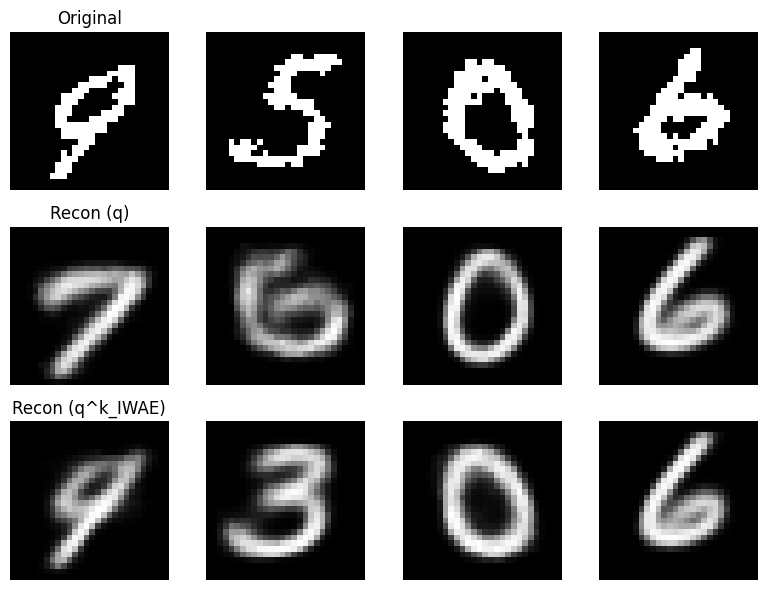

In [ ]:
display_reconstructions(iwae_diag, test_ds, k=50, num_images=4)

I will investigate the strength of the learning signal for the models trained with either $\mathcal{L}_{VAE}$ or $\mathcal{L}^k_{IWAE}$. The quantity that I will use to measure this is the signal-to-noise ratio of the gradients used in training. First we define (for the decoder parameters $\theta$):

$$
\begin{align}
\Delta_{VAE}(\theta) &:= \frac{\partial \mathcal{L}_{VAE}(\theta, \phi; x)}{\partial \theta},\\
\Delta^k_{IWAE}(\theta) &:= \frac{\partial \mathcal{L}^k_{IWAE}(\theta, \phi; x)}{\partial \theta},
\end{align}
$$
and similarly for the encoder parameters $\phi$. Then the signal-to-noise ratio is given by

$$
\begin{align}
SNR_{VAE}(\theta) &:= \left| \frac{\mathbb{E}[\Delta_{VAE}(\theta)]}{\sigma[\Delta_{VAE}(\theta)]} \right|,\\[1.5ex]
SNR_{IWAE}(\theta) &:= \left| \frac{\mathbb{E}[\Delta_{IWAE}(\theta)]}{\sigma[\Delta_{IWAE}(\theta)]} \right|,
\end{align}
$$
where $\sigma[\cdot]$ denotes the standard deviation of a random variable. The signal-to-noise ratio is defined similarly for the encoder parameters $\phi$. The expectation and standard deviation in the above definition is with respect to the Monte Carlo samples drawn from the posterior $q_\phi(z\mid x)$ in the definitions of $\mathcal{L}_{VAE}$ and $\mathcal{L}^k_{IWAE}$. I will assume that the encoder parameterises a diagonal Gaussian for the approximate posterior (as in the `VAEDiagonal` and `IWAEDiagonal` classes).

`compute_snr` computes estimates for the signal-to-noise ratio for a given list of trainable Variables, and given a single data example. It computes estimates for either $SNR_{VAE}$ or $SNR_{IWAE}$ by estimating the expectation and standard deviation with Monte Carlo samples. It takes the following arguments:

* `encoder` and `decoder` network objects. I assume that the encoder parameterises a diagonal Gaussian for the approximate posterior
* A list of Keras Variable objects (that belong to the encoder or decoder networks)
* An option to compute $SNR_{VAE}$ or $SNR_{IWAE}$
  * If computing $SNR_{IWAE}$, the function also requires $k$ as an argument
* Number of Monte Carlo samples to estimate the expectation and standard deviation in the definition of the $SNR$
* A `data` example that the loss is computed on.

The SNR is defined for each parameter. `compute_snr` returns a list of SNR values. This list contains Tensors with the same shape as in the list of trainable Variables input to the function.

In [ ]:
def compute_snr(encoder, decoder, variables, loss_type, data, num_mc_samples=10, k=50):
    """Compute signal-to-noise ratio (SNR) for a list of variables using VAE or IWAE loss."""
    grads = []
    for _ in range(num_mc_samples):
        with tf.GradientTape() as tape:
            x = tf.cast(data, tf.float32)
            batch_size = tf.shape(x)[0]
            # Encode input to get parameters of q(z|x)
            z_mean, z_log_var = encoder(x)
            z_std = tf.exp(0.5 * z_log_var)
            if loss_type == 'vae':
                # Sample z ~ q(z|x) using reparameterisation
                epsilon = tf.random.normal(shape=tf.shape(z_mean))
                z = z_mean + z_std * epsilon
                # Compute log-likelihood log p(x|z) using binary cross-entropy
                x_recon = decoder(z)
                x_flat = tf.reshape(x, [batch_size, -1])
                x_recon_flat = tf.reshape(x_recon, [batch_size, -1])
                bce = tf.keras.backend.binary_crossentropy(x_flat, x_recon_flat)
                nll_loss = tf.reduce_sum(bce, axis=1)
                # Compute KL divergence
                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                # Total loss (negative ELBO)
                loss = tf.reduce_mean(nll_loss + kl_loss)
            elif loss_type == 'iwae':
                # IWAE loss with k importance samples
                latent_dim = tf.shape(z_mean)[-1]
                epsilon = tf.random.normal(shape=(k, batch_size, latent_dim))
                z_samples = z_mean[None, :, :] + z_std[None, :, :] * epsilon
                # Decode each sample z_i to compute p(x|z_i)
                z_flat = tf.reshape(z_samples, [-1, latent_dim])
                x_recon = decoder(z_flat)
                x_recon = tf.reshape(x_recon, [k, batch_size, -1])
                x_flat = tf.reshape(x, [batch_size, -1])
                # Compute log-likelihood log p(x|z) using binary cross-entropy
                bce = tf.keras.backend.binary_crossentropy(x_flat[None, :, :], x_recon)
                log_p_x_given_z = -tf.reduce_sum(bce, axis=-1)
                # Compute log p(z) under standard normal prior
                log_p_z = -0.5 * tf.reduce_sum(z_samples**2 + tf.math.log(2. * np.pi), axis=-1)
                # Compute log q(z|x) under the diagonal Gaussian variational posterior
                z_var = tf.exp(z_log_var)
                log_q_z = -0.5 * tf.reduce_sum(
                    ((z_samples - z_mean[None, :, :]) ** 2) / z_var[None, :, :]
                    + z_log_var[None, :, :]
                    + tf.math.log(2. * np.pi),
                    axis=-1
                )
                # IWAE objective = log(1/k sum_i w_i) where w_i = p(x,z_i)/q(z_i|x)
                log_w = log_p_x_given_z + log_p_z - log_q_z
                log_iw = tf.reduce_logsumexp(log_w, axis=0) - tf.math.log(tf.cast(k, tf.float32))
                loss = -tf.reduce_mean(log_iw)
        grad = tape.gradient(loss, variables)
        grads.append(grad)
    # Stack gradients and compute SNR = |E[g]| / std[g]
    grads_stacked = [tf.stack([g[i] for g in grads], axis=0) for i in range(len(variables))]
    snrs = [tf.abs(tf.reduce_mean(g, axis=0)) / (tf.math.reduce_std(g, axis=0) + 1e-8) for g in grads_stacked]
    return snrs

Compute $SNR_{VAE}$ and $SNR_{IWAE}$ (with $k=50$) for the encoder trainable variables $\phi$, and for the decoder trainable variables $\theta$. The SNR values will be averaged over a batch of data drawn from the training Dataset.

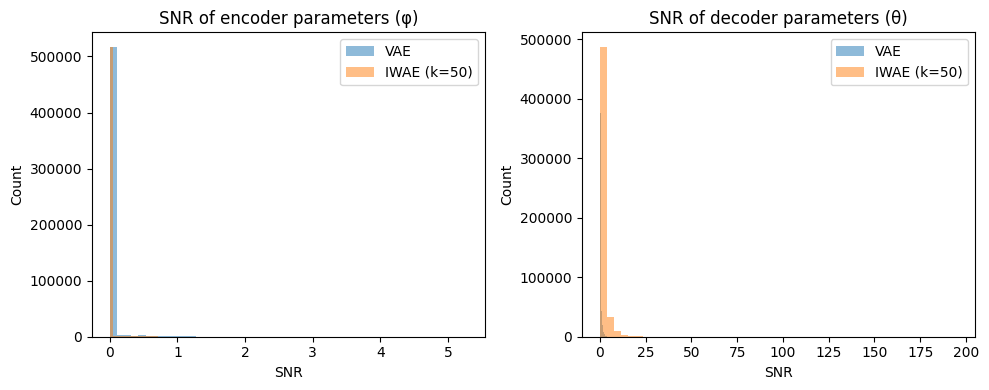

In [ ]:
# Take one batch of training data
batch = next(iter(train_ds))
# Get trainable variable lists
encoder_vars = encoder_iwae.trainable_variables
decoder_vars = decoder_iwae.trainable_variables
# Compute SNRs for VAE and IWAE (k=50)
snr_encoder_vae = compute_snr(encoder_iwae, decoder_iwae, encoder_vars, loss_type='vae', data=batch)
snr_decoder_vae = compute_snr(encoder_iwae, decoder_iwae, decoder_vars, loss_type='vae', data=batch)
snr_encoder_iwae = compute_snr(encoder_iwae, decoder_iwae, encoder_vars, loss_type='iwae', data=batch, k=50)
snr_decoder_iwae = compute_snr(encoder_iwae, decoder_iwae, decoder_vars, loss_type='iwae', data=batch, k=50)
# Flatten SNR tensors to 1D arrays for histogram plotting
def flatten_snr(snr_list):
    """Flatten a list of SNR tensors to a 1D numpy array."""
    return tf.concat([tf.reshape(s, [-1]) for s in snr_list], axis=0).numpy()
snr_phi_vae = flatten_snr(snr_encoder_vae)
snr_phi_iwae = flatten_snr(snr_encoder_iwae)
snr_theta_vae = flatten_snr(snr_decoder_vae)
snr_theta_iwae = flatten_snr(snr_decoder_iwae)
# Plot histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(snr_phi_vae, bins=50, alpha=0.5, label='VAE')
plt.hist(snr_phi_iwae, bins=50, alpha=0.5, label='IWAE (k=50)')
plt.title("SNR of encoder parameters (φ)")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(snr_theta_vae, bins=50, alpha=0.5, label='VAE')
plt.hist(snr_theta_iwae, bins=50, alpha=0.5, label='IWAE (k=50)')
plt.title("SNR of decoder parameters (θ)")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

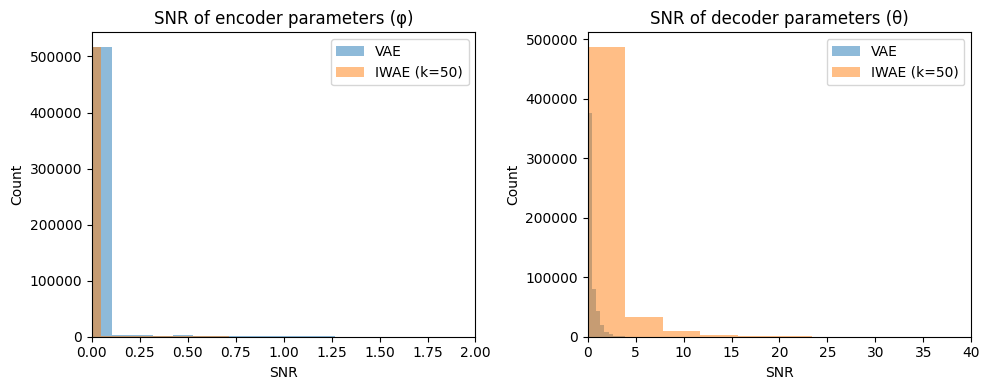

In [ ]:
# Plot histograms with clipped x-axis for better visibility
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(snr_phi_vae, bins=50, alpha=0.5, label='VAE')
plt.hist(snr_phi_iwae, bins=50, alpha=0.5, label='IWAE (k=50)')
plt.title("SNR of encoder parameters (φ)")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xlim(0, 2)
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(snr_theta_vae, bins=50, alpha=0.5, label='VAE')
plt.hist(snr_theta_iwae, bins=50, alpha=0.5, label='IWAE (k=50)')
plt.title("SNR of decoder parameters (θ)")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xlim(0, 40)
plt.legend()
plt.tight_layout()
plt.show()